# Examining a float file to see what it contains
#### Contents:
1. Importing packages and setting directories
2. Loading in a single float file
3. Plotting the float track
4. Exploring the float data
    - profile plots
    - section plots
5. Putting it all together and saving out a figure

----
Material by Seth Bushinsky

# 1. Setting up your notebook: packages and directories
One of the main differences I found when switching from Matlab to Python was that you had to import packages that you needed for each project. You can either import an entire package (like "import numpy as np") or part of a package (import matplotlib.ticker as mticker). I've commented out some packages that are not currently in use here that I often do use. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import os
# import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from scipy import stats
# from tqdm import tqdm
import xarray as xr

In [8]:
# Set directories
base_dir = "/Users/sethbushinsky/"

# I store my data and code  in separate directories, adjust as needed
data_dir = base_dir + "UHM_Ocean_BGC_Group Dropbox/Datasets/"
argo_path = data_dir + "Data_Products/BGC_ARGO_GLOBAL/2025_01_24/processed/for_external_sharing/"
glodap_path = data_dir + "Data_Products/GLODAP/"

# path for saving figures, etc
home_dir = base_dir + "UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/"
figure_dir = home_dir + "Projects/2025_10_BGC_Argo_Plus_Code_examples/plots/"
plot_ver = 'v_1'

# 2. Loading an Argo file and examine its contents

In [9]:
# Choose the float file you want to plot:
float_file = '1900650_Sprof_BGCArgoPlus.nc'


In [10]:
# load the file and explore the data
# note that xarray has "open_dataset" and "load_dataset" that seem identical. However, open_dataset is "lazy" and only accesses data as needed. "Load_dataset" loads data into memory, which takes more time and resources.

argo_n = xr.open_dataset(argo_path + float_file) 
argo_n

<xarray.Dataset> Size: 2MB
Dimensions:                         (N_PROF: 130, N_PARAM: 4, N_CALIB: 2,
                                     N_LEVELS: 71)
Coordinates:
    JULD                            (N_PROF) datetime64[ns] 1kB ...
    LATITUDE                        (N_PROF) float64 1kB ...
    LONGITUDE                       (N_PROF) float64 1kB ...
    PRES_ADJUSTED_BGCArgoPlus       (N_PROF, N_LEVELS) float32 37kB ...
  * N_LEVELS                        (N_LEVELS) int64 568B 0 1 2 3 ... 68 69 70
  * N_PROF                          (N_PROF) int64 1kB 0 1 2 3 ... 127 128 129
Dimensions without coordinates: N_PARAM, N_CALIB
Data variables: (12/76)
    DATA_TYPE                       object 8B ...
    FORMAT_VERSION                  object 8B ...
    HANDBOOK_VERSION                object 8B ...
    REFERENCE_DATE_TIME             object 8B ...
    DATE_CREATION                   object 8B ...
    DATE_UPDATE                     object 8B ...
    ...                              ...
    spiciness0                      (N_PROF, N_LEVELS) float64 74kB ...
    cons_temp                       (N_PROF, N_LEVELS) float64 74kB ...
    gamma                           (N_PROF, N_LEVELS) float64 74kB ...
    depth                           (N_PROF, N_LEVELS) float64 74kB ...
    MLD                             (N_PROF) float64 1kB ...
    DOXY_SAT                        (N_PROF, N_LEVELS) float64 74kB ...
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2024-07-15T14:29:53Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

In [11]:
# List different variable types contained in the float file by their dimensions
variables = argo_n.keys()
n_levels = argo_n['N_LEVELS'].shape
n_profiles = argo_n['N_PROF'].shape

variable_dimensions = [0, 1, 2]

for dim in variable_dimensions:
    print(f"Variables with dimension length of {dim}")
    for var in variables:
        if len(argo_n[var].shape) == dim:
            print(f"  {var}")



Variables with dimension length of 0
  DATA_TYPE
  FORMAT_VERSION
  HANDBOOK_VERSION
  REFERENCE_DATE_TIME
  DATE_CREATION
  DATE_UPDATE
  CTD_PRES_model
  CTD_TEMP_model
  CTD_CNDC_model
  OPTODE_DOXY_model
  O2_cal_type
  WMO_ID
  PRES_ADJUSTED_BGCArgoPlus_flag
  TEMP_ADJUSTED_BGCArgoPlus_flag
  PSAL_ADJUSTED_BGCArgoPlus_flag
  DOXY_ADJUSTED_BGCArgoPlus_flag
Variables with dimension length of 1
  PLATFORM_NUMBER
  PROJECT_NAME
  PI_NAME
  CYCLE_NUMBER
  DIRECTION
  DATA_CENTRE
  PLATFORM_TYPE
  FLOAT_SERIAL_NO
  FIRMWARE_VERSION
  WMO_INST_TYPE
  JULD_QC
  JULD_LOCATION
  POSITION_QC
  POSITIONING_SYSTEM
  CONFIG_MISSION_NUMBER
  PROFILE_PRES_QC
  PROFILE_TEMP_QC
  PROFILE_PSAL_QC
  PROFILE_DOXY_QC
  MLD
Variables with dimension length of 2
  STATION_PARAMETERS
  PARAMETER_DATA_MODE
  PRES
  PRES_QC
  PRES_ADJUSTED
  PRES_ADJUSTED_QC
  PRES_ADJUSTED_ERROR
  TEMP
  TEMP_QC
  TEMP_dPRES
  TEMP_ADJUSTED
  TEMP_ADJUSTED_QC
  TEMP_ADJUSTED_ERROR
  PSAL
  PSAL_QC
  PSAL_dPRES
  PSAL_ADJUST

# 3. Plot the float track 
---
To do this we will use the Cartopy package, which has handy geographic plotting functions. A few things to keep in mind when dealing with spatial plots:

- Longitude conventions (-180/180 or 0/360). Both are commonly used, but some packages accept only one.

- Projections: The projection is how a set of coordinates is displayed on a map - basically how do you display data from an oblate spheroid (the Earth) onto a flat screen. There are many projections out there, right now I'm a fan of Interrupted Goode Homolosime projectsion (see below). 

- Data Projection vs. Map Projection. Cartopy needs you to pass a simple lat/lon projection type (PlateCarree shown below) for your data, while your map Projection can be anything you choose. I mention this because if you use the map projection for both your data "transform" and your map projection, your data will not show up in the correct place. I've done this enough that I assume others will make the same mistake.

Text(0.5, 1.0, 'Float 1900650 Track')

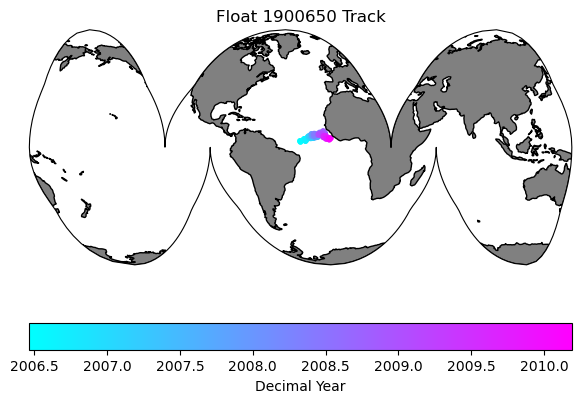

In [ ]:
# First let's make a map of the figure track so we know where it is: 

# For plotting it will be easier if we create a time variable in decimal years
argo_n['decimal_year'] = (['N_PROF'],np.empty(argo_n.PRES_ADJUSTED.shape[0])) # add an empty variable 
argo_n.decimal_year[:] = np.nan # set all values to nan
date_time = pd.to_datetime(argo_n.JULD.values) # get out the time, converted to a Pandas datetime
year = date_time.year # extract the year
decimal_year = year + (date_time.day_of_year - 1) / 365.25 # extract the day of year, convert to decimal year and add the year
argo_n.decimal_year[:] = decimal_year # save into the array. This step isn't really necessary here, but keeps things organized and you could save it out for later use. I should probably just add decimal year to the files..

data_proj = ccrs.PlateCarree(central_longitude=0)
map_proj =ccrs.InterruptedGoodeHomolosine(central_longitude=argo_n['LONGITUDE'][0].values, globe=None, emphasis='ocean')

fig = plt.figure(figsize=(7,5))

ax0 = fig.add_subplot(1,1,1, projection=map_proj)
ax0.set_global()
ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=[.5, .5 ,.5]))

map = ax0.scatter(argo_n.LONGITUDE.values, argo_n.LATITUDE.values, s=10, c=argo_n.decimal_year, transform=data_proj, cmap='cool')
plt.colorbar(map, label='Decimal Year', orientation='horizontal')
plt.title('Float ' + str(argo_n['WMO_ID'].values) + ' Track')




# 4. Exploring the float data
---
## Profile Plots
Let's explore the data for a variable. Choose one of the measured variables and we will plot the first 5 profiles to get a sense of the data


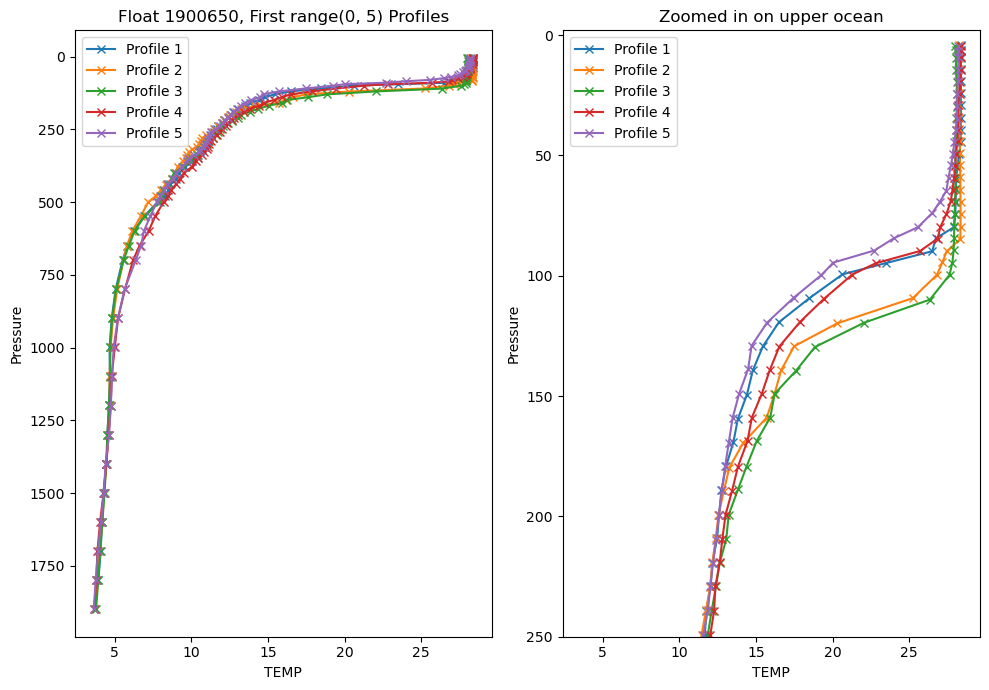

In [ ]:
var_choice = 'TEMP'

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# We can plot the first X profiles to get a look at the data:
profiles = range(5)

for p in profiles:
    ax1.plot(argo_n[var_choice][p, :], argo_n['PRES'][p, :], marker='x', label=f'Profile {p+1}')
    ax2.plot(argo_n[var_choice][p, :], argo_n['PRES'][p, :], marker='x', label=f'Profile {p+1}')
ax1.invert_yaxis()
ax1.set_xlabel(var_choice)
ax1.set_ylabel('Pressure')
ax1.legend()
ax1.set_title(f'Float {argo_n['WMO_ID'].values}, First {profiles} Profiles')
# our second axis is zoomed in to the upper 250m
ax2.invert_yaxis()
ax2.set_xlabel(var_choice)
ax2.set_ylabel('Pressure')
ax2.legend()
ax2.set_title('Zoomed in on upper ocean')
max_pres = 250
ax2.set_ylim(max_pres, -2)
plt.tight_layout()


Looking at individual profiles can really help you understand how the water column evolves over depth and time, but it is difficult to look at too many at once.

If we make the same plots, but this time use every profile this is what we get:

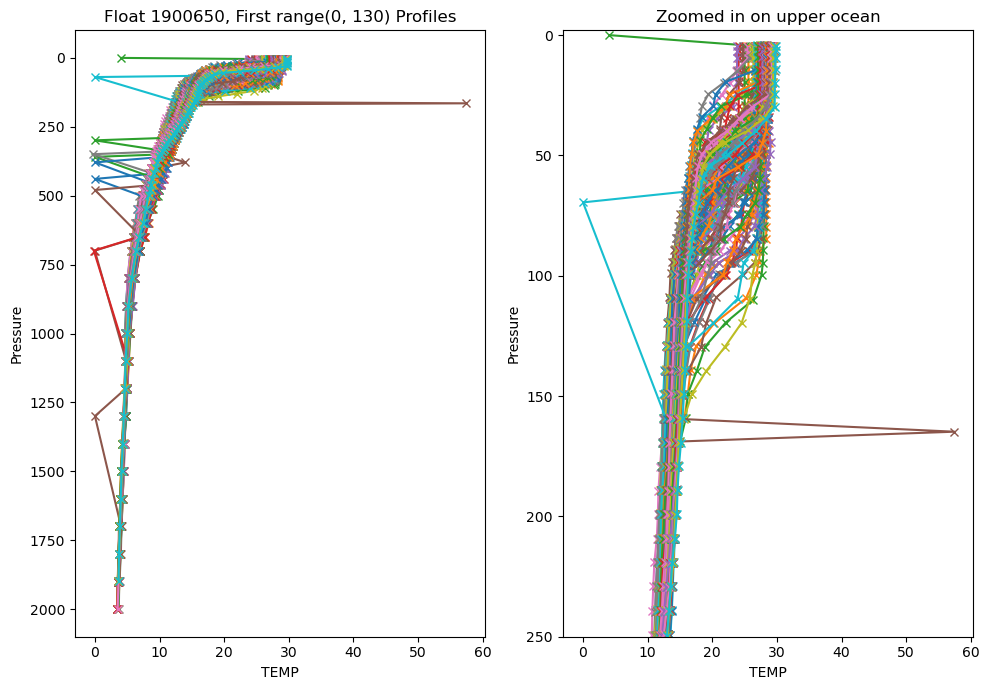

In [ ]:

var_choice = 'TEMP'
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# We can plot the first 5 profiles to get a look at the data:
profiles = range(len(argo_n['PRES']))

for p in profiles:
    ax1.plot(argo_n[var_choice][p, :], argo_n['PRES'][p, :], marker='x', label=f'Profile {p+1}')

    ax2.plot(argo_n[var_choice][p, :], argo_n['PRES'][p, :], marker='x', label=f'Profile {p+1}')
ax1.invert_yaxis()
ax1.set_xlabel(var_choice)
ax1.set_ylabel('Pressure')
ax1.set_title(f'Float {argo_n['WMO_ID'].values}, First {profiles} Profiles')

# ax1.legend() # commenting out the legend since there are way too many profiles to show

# our second axis is zoomed in to the upper 250m
ax2.invert_yaxis()
ax2.set_xlabel(var_choice)
ax2.set_ylabel('Pressure')
# ax2.legend()
ax2.set_title('Zoomed in on upper ocean')

max_pres = 250
ax2.set_ylim(max_pres, -2)
plt.tight_layout()


Well that looks pretty terrible. My chosen float has a lot of outliers, plus there's too much data overlain. We have so many outliers because we are using the raw data. 

Let's use the adjusted data instead:

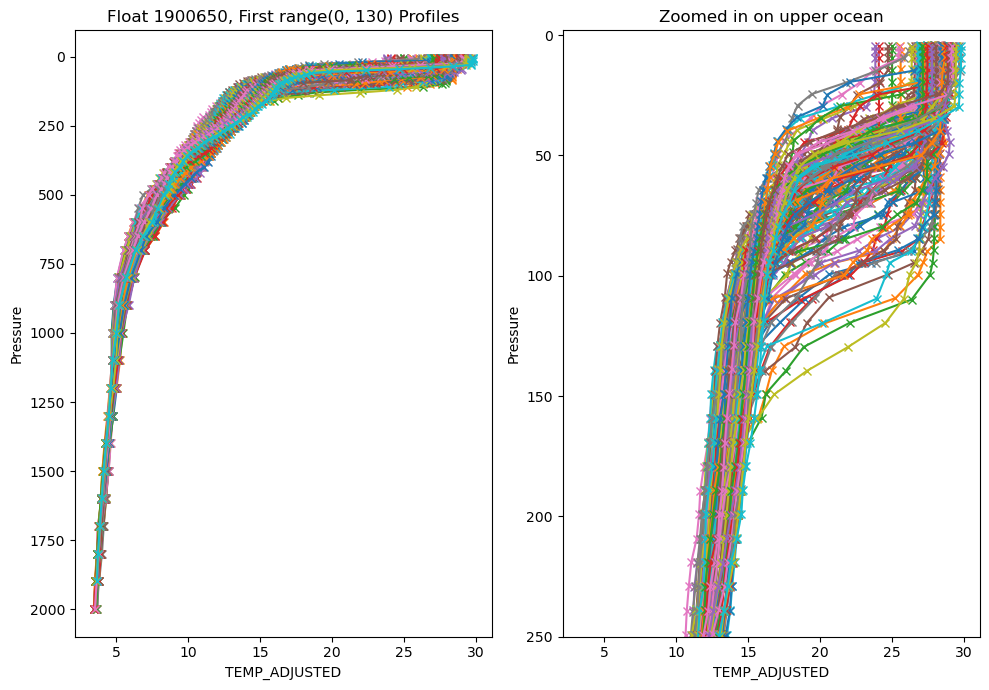

In [ ]:
var_choice = 'TEMP_ADJUSTED'

fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# We can plot the first 5 profiles to get a look at the data:
profiles = range(len(argo_n['PRES']))

for p in profiles:
    ax1.plot(argo_n[var_choice][p, :], argo_n['PRES'][p, :], marker='x', label=f'Profile {p+1}')

    ax2.plot(argo_n[var_choice][p, :], argo_n['PRES'][p, :], marker='x', label=f'Profile {p+1}')
ax1.invert_yaxis()
ax1.set_xlabel(var_choice)
ax1.set_ylabel('Pressure')
ax1.set_title(f'Float {argo_n['WMO_ID'].values}, First {profiles} Profiles')

# ax1.legend() # commenting out the legend since there are way too many profiles to show

# our second axis is zoomed in to the upper 250m
ax2.invert_yaxis()
ax2.set_xlabel(var_choice)
ax2.set_ylabel('Pressure')
# ax2.legend()
ax2.set_title('Zoomed in on upper ocean')

max_pres = 250
ax2.set_ylim(max_pres, -2)
plt.tight_layout()


**Much better.** It is very unlikely that temperature would have so may spikes in the 'ADJUSTED' data, but that gives you an idea of the QC that gets applied. 

However, there are still too many profiles to make much sense of what is going on. There are a number of ways you can tackle that, but what I ususally start with is to make a section plot of the data.

## Section plots
---
We are also going to use the **BGCArgoPlus variables**, since those have had our additional QC applied.

Text(0.5, 0.98, 'Float 1900650 - Left: Original Data Spacing, Right: Filtered Vertical Gaps')

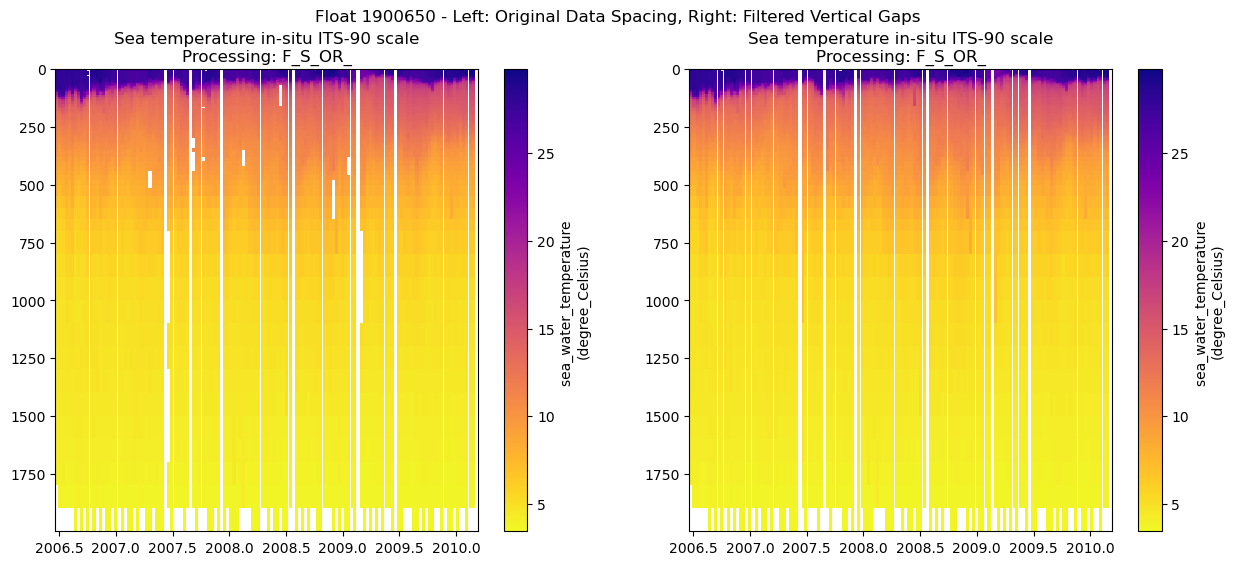

In [ ]:
pres_name = 'PRES_ADJUSTED_BGCArgoPlus'
var_name = 'TEMP_ADJUSTED_BGCArgoPlus'

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


color_map = 'plasma_r'
if ~np.all(np.isnan(argo_n[var_name])):
    var_min = np.nanmin(argo_n[var_name])
    var_max = np.nanmax(argo_n[var_name])     
else:
    print(f'All values for {var_name} are NaN, plot will fail')


# There are a lot of ways to make a section plot. I'm going to show two ways, one that maintains the original data spacing, so that you get a sense of where measurements are actually made, and one that fills in the gaps vertically, though doesn't interpolate through time in case there are gaps in the data

# For both of these we will loop through each profile to plot the data. This is slow, but keeps use from having to smooth/interpolate too much for now.
for p in range(0, len(argo_n.N_PROF)):

    # We are essentially going to call pcolormesh for each profile individually. We do this because the sample depths are not exactly the same from profile to profile.
    # To do this we need to create a l x 2 array, where l is the number of pressures and the two columns correspond to the width of the x-axis time for each profile that we plot.
    p_p = argo_n[pres_name][p, ~np.isnan(argo_n[pres_name][p,:])].values # pressure
    t_p = np.array([argo_n.decimal_year[p].item(), argo_n.decimal_year[p].values + np.nanmedian(np.diff(argo_n.decimal_year))]) # Time. Try padding with median difference between profile times instead of next profile in case of large gaps

    if t_p.size==1:
        t_p = np.tile(t_p, (2,1))
        t_p[1] = t_p[1] + (argo_n.decimal_year[p] - argo_n.decimal_year[p-1]).values
    elif np.isnan(t_p).any(): # if any values in t_p are nans
        if np.isnan(t_p).all(): # if all are nans, continue
            continue
        elif np.isnan(t_p[0]):
            t_p[0] = t_p[1] - 10/365
        else:
            t_p[1] = t_p[0] + 10/365
    
    # Create the meshgrid, a regular grid of x/y values that will be the same shape as the data we will plot
    xl,yl = np.meshgrid(t_p, p_p)

    # extracting the variable that we want to plot
    c = argo_n[var_name][p,~np.isnan(argo_n[pres_name][p,:])].values

    # extracting the variable, this time removing any vertical gaps
    c2= argo_n[var_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
    
    if c.size==0:
        continue
    c = np.tile(c, (2,1))
    c = c.T

    # we'll need a different shape x/y array to match the size of c2 (it is likely smaller in the vertical direction due to removed gaps)
    p_p2 = argo_n[pres_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
    xl2, yl2 = np.meshgrid(t_p, p_p2)

    c2 = np.tile(c2, (2,1))
    c2 = c2.T

    try:
        pc = ax.pcolormesh(xl, yl, c[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)
        pc2 = ax2.pcolormesh(xl2, yl2, c2[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)

    except:
        print(var_name + ' failed to plot')
        print(c.shape)
        print(c2.shape)

cl1 = plt.colorbar(pc, ax=ax)
ax.set_ylim(argo_n[pres_name].max().values, 0)
ax.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
ax.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
cl1.set_label(f'{argo_n[var_name].standard_name} \n({argo_n[var_name].units})')

cl2 = plt.colorbar(pc2, ax=ax2)
ax2.set_ylim(argo_n[pres_name].max().values, 0)
ax2.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
ax2.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
cl2.set_label(f'{argo_n[var_name].standard_name} \n({argo_n[var_name].units})')

fig.suptitle(f"Float {argo_n['WMO_ID'].values} - Left: Original Data Spacing, Right: Filtered Vertical Gaps")




You can see some gaps where the outliers were removed. For some variables, especially the BGC ones, there are often many fewer samples per profile, so the gaps can be large and make it difficult to see the overall patterns in the data.

Because of the way we wrote the last script, where we set a "var_name" variable, we can easily make a loop to look at other variables as well. 

Let's combine the section where we displayed all variable names with the section plot code to show all variables with 2 dimensions (i.e. profiles x levels):

In [18]:
# List different variable types contained in the float file by their dimensions
variables = argo_n.keys()
n_levels = argo_n['N_LEVELS'].shape
n_profiles = argo_n['N_PROF'].shape
vars_to_plot = []

target_dim = 2
for var in variables:
    if len(argo_n[var].shape) == target_dim:
        vars_to_plot.append(var)

print(f"Variables to plot: {vars_to_plot}")

Variables to plot: ['STATION_PARAMETERS', 'PARAMETER_DATA_MODE', 'PRES', 'PRES_QC', 'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PRES_ADJUSTED_ERROR', 'TEMP', 'TEMP_QC', 'TEMP_dPRES', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'TEMP_ADJUSTED_ERROR', 'PSAL', 'PSAL_QC', 'PSAL_dPRES', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_QC', 'PSAL_ADJUSTED_ERROR', 'DOXY', 'DOXY_QC', 'DOXY_dPRES', 'DOXY_ADJUSTED', 'DOXY_ADJUSTED_QC', 'DOXY_ADJUSTED_ERROR', 'TEMP_ADJUSTED_BGCArgoPlus', 'PSAL_ADJUSTED_BGCArgoPlus', 'DOXY_ADJUSTED_BGCArgoPlus', 'Sigma_theta_gsw', 'sigma0', 'spiciness0', 'cons_temp', 'gamma', 'depth', 'DOXY_SAT']


Okay thats more than we want. We can only look for variable names within our 2-dimensional variables that end in '_BGCArgoPlus'


In [19]:
vars_to_plot = [var for var in vars_to_plot if var.endswith('_BGCArgoPlus')]
print(f"Filtered variables to plot: {vars_to_plot}")

Filtered variables to plot: ['TEMP_ADJUSTED_BGCArgoPlus', 'PSAL_ADJUSTED_BGCArgoPlus', 'DOXY_ADJUSTED_BGCArgoPlus']


# 5. Putting it all together:
---
Now we can pass those through to our adjusted section plot code. To keep the figure from getting too large, we'll only plot the filled figures for each variable. 

I'll mainly just comment out the extra lines we are not using, so that it is clear what has been changed.

Finally, we'll include the map of the float track and save out the figure in whichever folder you established for figures 


Figure saved to /Users/sethbushinsky/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Projects/2025_10_BGC_Argo_Plus_Code_examples/plots/, with the filename: Float_1900650_BGCArgoPlus_Section_Plots_v_1.png


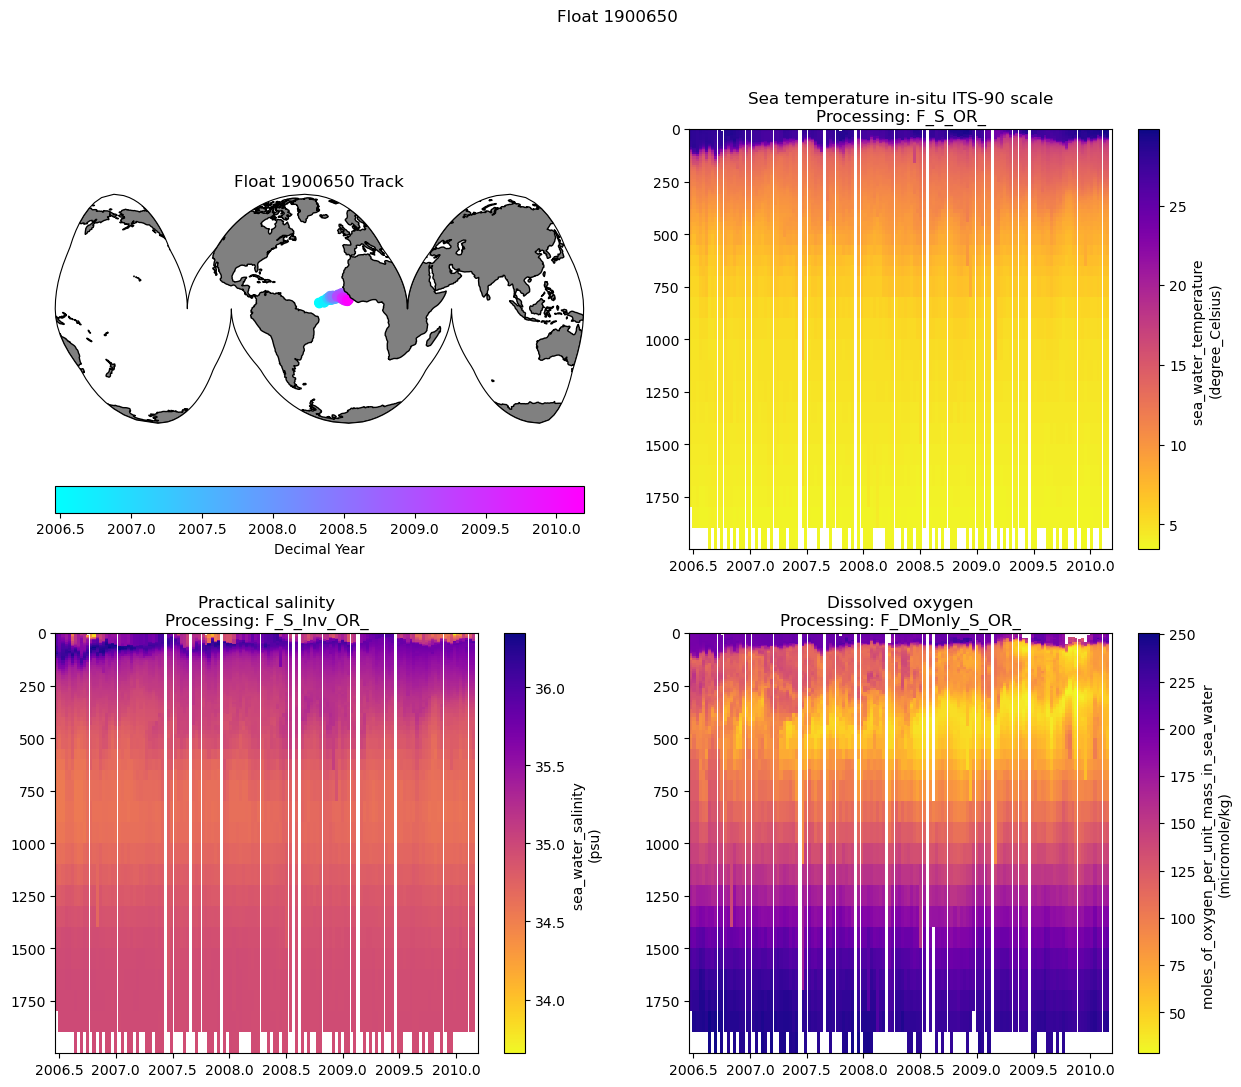

In [20]:
pres_name = 'PRES_ADJUSTED_BGCArgoPlus'

num_rows = int(np.ceil((len(vars_to_plot)+1)/2))
fig = plt.figure(figsize=(15, 6*num_rows))

plot_num = 1

ax0 = fig.add_subplot(num_rows,2,plot_num, projection=map_proj)

data_proj = ccrs.PlateCarree(central_longitude=0)
map_proj =ccrs.InterruptedGoodeHomolosine(central_longitude=argo_n['LONGITUDE'][0].values, globe=None, emphasis='ocean')

ax0.set_global()
ax0.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=[.5, .5 ,.5]))

map = ax0.scatter(argo_n.LONGITUDE.values, argo_n.LATITUDE.values, c=argo_n.decimal_year, transform=data_proj, cmap='cool')
plt.colorbar(map, label='Decimal Year', orientation='horizontal')
plt.title('Float ' + str(argo_n['WMO_ID'].values) + ' Track')


for var_name in vars_to_plot:
    plot_num += 1
    ax2 = fig.add_subplot(num_rows,2,plot_num)
    
    # For plotting it will be easier if we create a time variable in decimal years
    argo_n['decimal_year'] = (['N_PROF'],np.empty(argo_n.PRES_ADJUSTED.shape[0])) # add an empty variable 
    argo_n.decimal_year[:] = np.nan # set all values to nan
    date_time = pd.to_datetime(argo_n.JULD.values) # get out the time, converted to a Pandas datetime
    year = date_time.year # extract the year
    decimal_year = year + (date_time.day_of_year - 1) / 365.25 # extract the day of year, convert to decimal year and add the year
    argo_n.decimal_year[:] = decimal_year # save into the array. This step isn't really necessary here, but keeps things organized and you could save it out for later use. I should probably just add decimal year to the files..


    color_map = 'plasma_r'
    if ~np.all(np.isnan(argo_n[var_name])):
        var_min = np.nanmin(argo_n[var_name])
        var_max = np.nanmax(argo_n[var_name])     
    else:
        print(f'All values for {var_name} are NaN, plot will fail')


    # There are a lot of ways to make a section plot. I'm going to show two ways, one that maintains the original data spacing, so that you get a sense of where measurements are actually made, and one that fills in the gaps vertically, though doesn't interpolate through time in case there are gaps in the data

    # For both of these we will loop through each profile to plot the data. This is slow, but keeps use from having to smooth/interpolate too much for now.

    for p in range(0, len(argo_n.N_PROF)):
        # p_p = argo_n[pres_name][p, ~np.isnan(argo_n[pres_name][p,:])].values
        t_p = np.array([argo_n.decimal_year[p].item(), argo_n.decimal_year[p].values + np.nanmedian(np.diff(argo_n.decimal_year))]) # try padding with median difference between profile times instead of next profile in case of large gaps

        # t_p = argo_n.decimal_year[p:p+2].values
        if t_p.size==1:
            t_p = np.tile(t_p, (2,1))
            t_p[1] = t_p[1] + (argo_n.decimal_year[p] - argo_n.decimal_year[p-1]).values
        elif np.isnan(t_p).any(): # if any values in t_p are nans
            if np.isnan(t_p).all(): # if all are nans, continue
                continue
            elif np.isnan(t_p[0]):
                t_p[0] = t_p[1] - 10/365
            else:
                t_p[1] = t_p[0] + 10/365
        # xl,yl = np.meshgrid(t_p, p_p)

        # extracting the variable that we want to plot
        # c = argo_n[var_name][p,~np.isnan(argo_n[pres_name][p,:])].values

        # extracting the variable, this time removing any vertical gaps
        c2= argo_n[var_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
        
        # if c.size==0:
        #     continue
        # else:
        #     c = np.tile(c, (2,1))
        #     c = c.T
        #     pc = ax.pcolormesh(xl, yl, c[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)
       
        # we'll need a different shape x/y array to match the size of c2 (it is likely smaller in the vertical direction due to removed gaps)
        if c2.size==0:
            continue
        else:
            p_p2 = argo_n[pres_name][p,np.logical_and(~np.isnan(argo_n[var_name][p,:]), ~np.isnan(argo_n[pres_name][p,:]))].values
            xl2, yl2 = np.meshgrid(t_p, p_p2)

            c2 = np.tile(c2, (2,1))
            c2 = c2.T

            pc2 = ax2.pcolormesh(xl2, yl2, c2[0:-1,0:-1], cmap=color_map, shading='flat', vmin=var_min, vmax=var_max)

      

    # cl1 = plt.colorbar(pc, ax=ax)
    # ax.set_ylim(argo_n[pres_name].max().values, 0)
    # ax.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
    # ax.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    # cl1.set_label(f'{argo_n[var_name].standard_name} \n({argo_n[var_name].units})')

    cl2 = plt.colorbar(pc2, ax=ax2)
    ax2.set_ylim(argo_n[pres_name].max().values, 0)
    ax2.set_xlim(argo_n['decimal_year'][0], argo_n['decimal_year'][-1])
    ax2.set_title(argo_n[var_name].long_name + '\nProcessing: ' + argo_n[var_name + '_flag'].values.item())
    cl2.set_label(f'{argo_n[var_name].standard_name} \n({argo_n[var_name].units})')

fig.suptitle(f"Float {argo_n['WMO_ID'].values}")
fig.savefig(figure_dir + f"Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png", dpi=300)

print(f"Figure saved to {figure_dir}, with the filename: Float_{argo_n['WMO_ID'].values}_BGCArgoPlus_Section_Plots_{plot_ver}.png")